# Word2Vec

Let's work on skipgram-based implementation of word2vec.

In [1]:
# for numerical computations
import numpy as np
# neural network libraries
import torch
import torch.nn as nn
import torch.optim as optim
# for plotting
import matplotlib.pyplot as plt

In [2]:
np.__version__, torch.__version__

('2.4.1', '2.9.1')

In [3]:
import matplotlib
matplotlib.__version__

'3.10.8'

## 1. Define some very simple data for understanding

In [4]:
# window size is 1 (one word to the left and one to the right)
corpus = ["apple banana fruit", "banana apple fruit", "banana fruit apple",
                 "dog cat animal", "cat animal dog", "cat dog animal"]

In [5]:
# 1. tokenization - basic tokenization by splitting on spaces
# tokenization is based on words here - there are advanced tokenization techniques like using root words, prefixes, suffixes, etc.
corpus = [sent.split(" ") for sent in corpus]
corpus

[['apple', 'banana', 'fruit'],
 ['banana', 'apple', 'fruit'],
 ['banana', 'fruit', 'apple'],
 ['dog', 'cat', 'animal'],
 ['cat', 'animal', 'dog'],
 ['cat', 'dog', 'animal']]

In [6]:
#get word sequences 
flatten = lambda l: [item for sublist in l for item in sublist]
# get unique words and 
vocab = list(set(flatten(corpus))) # vocabs = all unique words in the corpus
vocab

['banana', 'apple', 'fruit', 'dog', 'cat', 'animal']

In [7]:
# numericalization
# create handy mapping between integers and words
# done by creaing disctionary
word2index = {w: i for i, w in enumerate(vocab)}
print(word2index)

{'banana': 0, 'apple': 1, 'fruit': 2, 'dog': 3, 'cat': 4, 'animal': 5}


In [8]:
#vocab size
voc_size = len(vocab)
print(voc_size)

6


In [9]:
#append UNK
vocab.append('<UNK>')

In [10]:
vocab

['banana', 'apple', 'fruit', 'dog', 'cat', 'animal', '<UNK>']

In [11]:
word2index['<UNK>'] = 0

In [12]:
#just in case we need to use , index to word
index2word = {v:k for k, v in word2index.items()} 
index2word

{0: '<UNK>', 1: 'apple', 2: 'fruit', 3: 'dog', 4: 'cat', 5: 'animal'}

## 2. Prepare train data

In [13]:
for c in corpus:
    print(c)

['apple', 'banana', 'fruit']
['banana', 'apple', 'fruit']
['banana', 'fruit', 'apple']
['dog', 'cat', 'animal']
['cat', 'animal', 'dog']
['cat', 'dog', 'animal']


In [14]:
# create pais of center word and context word (outside words)
# loop each corpus
    # loop each document
        # look from the 2nd word unitl second last word
            # get the center word
            # outside words = 2 words (left and right of center word)
            # for each of these two outside words, we gonna append to a list
                # center, outside1; center, outside2

In [15]:
def random_batch(batch_size, word_sequence):
    
    # Make skip gram of one size window
    skip_grams = []
    # loop each word sequence
    # we starts from 1 because 0 has no context or complete context (left and right)
    # we stop at second last for the same reason - has no complete context
    for sent in corpus:
        for i in range(1, len(sent) - 1):
            target = word2index[sent[i]] # center word in integers
            context = [word2index[sent[i - 1]], word2index[sent[i + 1]]] # outside words in integers
            for w in context:
                skip_grams.append([target, w])
    
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False) #randomly pick without replacement
        
    for i in random_index:
        random_inputs.append([skip_grams[i][0]])  # target, e.g., 2
        random_labels.append([skip_grams[i][1]])  # context word, e.g., 3
            
    return np.array(random_inputs), np.array(random_labels)

### Testing the method

In [16]:
#testing the method
batch_size = 2 # mini-batch size
input_batch, target_batch = random_batch(batch_size, corpus)

print("Input: ", input_batch)
print("Target: ", target_batch)
#we will convert them to tensor during training, so don't worry...

Input:  [[5]
 [2]]
Target:  [[4]
 [0]]


In [17]:
input_batch.shape, target_batch.shape

((2, 1), (2, 1))

## 3. Model

$$J(\theta) = -\frac{1}{T}\sum_{t=1}^{T}\sum_{\substack{-m \leq j \leq m \\ j \neq 0}}\log P(w_{t+j} | w_t; \theta)$$

where $P(w_{t+j} | w_t; \theta) = $

$$P(o|c)=\frac{\exp(\mathbf{u_o^{\top}v_c})}{\sum_{w=1}^V\exp(\mathbf{u_w^{\top}v_c})}$$

where $o$ is the outside words and $c$ is the center word

In [18]:
class Skipgram(nn.Module):
    
    def __init__(self, vocab_size, emb_size):
        super(Skipgram,self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, emb_size)
        self.embedding_u = nn.Embedding(vocab_size, emb_size)
    
    def forward(self, center_words, target_words, all_vocabs):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]
        all_embeds    = self.embedding_u(all_vocabs) #   [batch_size, voc_size, emb_size]
        
        scores      = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]

        norm_scores = all_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, voc_size, emb_size] @ [batch_size, emb_size, 1] = [batch_size, voc_size, 1] = [batch_size, voc_size]

        nll = -torch.mean(torch.log(torch.exp(scores)/torch.sum(torch.exp(norm_scores), 1).unsqueeze(1))) # log-softmax
        # scalar (loss must be scalar)    
            
        return nll # negative log likelihood

# embedding shape => batch_size, em

## 4. Training

In [19]:
batch_size     = 2 # mini-batch size
embedding_size = 2 #so we can later plot
model          = Skipgram(voc_size, embedding_size)

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

#use for the normalized term in the probability calculation
all_vocabs = prepare_sequence(list(vocab), word2index).expand(batch_size, len(vocab))  # [batch_size, voc_size]
all_vocabs.shape

torch.Size([2, 7])

In [21]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [22]:
import time

# Training
num_epochs = 5000
for epoch in range(num_epochs):
    
    start = time.time()
    
    # get batch data
    input_batch, target_batch = random_batch(batch_size, corpus)
    input_batch  = torch.LongTensor(input_batch)  #[batch_size, 1]
    target_batch = torch.LongTensor(target_batch) #[batch_size, 1]

    # predict loss
    optimizer.zero_grad()
    loss = model(input_batch, target_batch, all_vocabs)
    
    # backpropagation
    loss.backward()
    
    # update alpha
    optimizer.step()
    
    end = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start, end)

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")


Epoch: 1000 | cost: 1.541784 | time: 0m 0s
Epoch: 2000 | cost: 1.703758 | time: 0m 0s
Epoch: 3000 | cost: 1.610825 | time: 0m 0s
Epoch: 4000 | cost: 0.844709 | time: 0m 0s
Epoch: 5000 | cost: 0.794343 | time: 0m 0s


## 5. Plotting the embeddings

Is fruit near to banana? Is fruit far from cat ?

In [23]:
#list of vocabs
vocab[:10]

['banana', 'apple', 'fruit', 'dog', 'cat', 'animal', '<UNK>']

In [24]:
banana = torch.tensor([[word2index['banana']]])
banana

tensor([[0]])

In [25]:
banana_embed_v = model.embedding_v(banana)
banana_embed_u = model.embedding_u(banana)
banana_embed_v, banana_embed_u

(tensor([[[-1.6616, -0.7033]]], grad_fn=<EmbeddingBackward0>),
 tensor([[[ 1.4764, -1.9660]]], grad_fn=<EmbeddingBackward0>))

In [28]:
banana_embed =  (banana_embed_v + banana_embed_u) /2 

In [29]:
word = vocab[0]
word 

'banana'

In [ ]:
#numericalization
id = word2index[word]
id

0

In [ ]:
id_tensor = torch.LongTensor([id])
id_tensor

tensor([0])

In [ ]:
#get the embedding by averaging
v_embed = model.embedding_v(id_tensor)
u_embed = model.embedding_u(id_tensor)

v_embed, u_embed

(tensor([[-1.1529, -1.2574]], grad_fn=<EmbeddingBackward0>),
 tensor([[-1.0543, -0.4413]], grad_fn=<EmbeddingBackward0>))

In [ ]:
#average to get the word embedding
word_embed = (v_embed + u_embed) / 2
word_embed[0][1]

tensor(-0.8493, grad_fn=<SelectBackward0>)

In [ ]:
def get_embed_chakyvideo(word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']

    word = torch.LongTensor([word2index[word]])

    embed_v = model.embedding_v(word)
    embed_u = model.embedding_u(word)
    embed = (embed_v + embed_u) / 2

    return embed[0][0].item(), embed[0][1].item()

In [ ]:
#let's write a function to get embedding given a word
def get_embed(word):
    id_tensor = torch.LongTensor([word2index[word]])
    v_embed = model.embedding_v(id_tensor)
    u_embed = model.embedding_u(id_tensor) 
    word_embed = (v_embed + u_embed) / 2 
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

In [ ]:
get_embed('fruit')

(1.2314226627349854, 0.6353347301483154)

In [ ]:
get_embed('banana')

(1.348540186882019, 0.4124754071235657)

In [ ]:
get_embed('cat')

(-1.3295440673828125, -0.48725149035453796)

In [ ]:
get_embed('dog')

(-1.103606939315796, -0.8493368029594421)

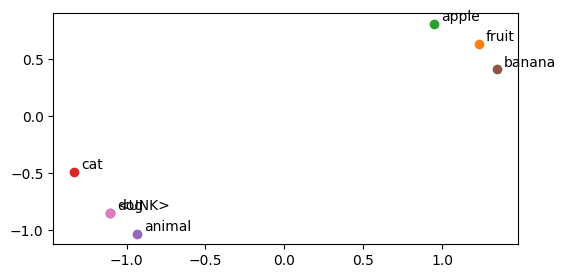

In [ ]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocab[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## 6. Cosine similarity

Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$ 

If $p$ and $q$ is super similar, the result is 1 otherwise 0.

In [ ]:
vocab

['dog', 'fruit', 'apple', 'cat', 'animal', 'banana', '<UNK>']

In [ ]:
#let's try similarity between first and second, and second and third
cat          = get_embed('cat')
fruit        = get_embed('fruit')
animal       = get_embed('animal')

In [ ]:
np.array(cat) @ np.array(fruit) 

np.float64(-1.9467984898188107)

In [ ]:
np.array(cat) @ np.array(animal) 

np.float64(1.744612371516169)

In [ ]:
#numpy version
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim
    
print(f"cat vs. fruit: ",        cos_sim(cat, fruit))
print(f"cat vs. animal: ",       cos_sim(cat, animal))
print(f"cat vs. cat: ",          cos_sim(cat, cat))

cat vs. fruit:  -0.9921933944854652
cat vs. animal:  0.8857921869342228
cat vs. cat:  1.0


In [ ]:
#scipy version
from scipy import spatial

def cos_sim(a, b):
    cos_sim = 1 - spatial.distance.cosine(a, b)  #distance = 1 - similarlity, because scipy only gives distance
    return cos_sim

print(f"cat vs. fruit: ",        cos_sim(cat, fruit))
print(f"cat vs. animal: ",       cos_sim(cat, animal))
print(f"cat vs. cat: ",          cos_sim(cat, cat))

cat vs. fruit:  -0.9921933944854651
cat vs. animal:  0.8857921869342228
cat vs. cat:  1.0
